# Importar lo necesario

In [1]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from torchsummary import summary

#### configuramos el `device` acorde al device disponible




In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"


#**MNIST data base**
# Ejemplo de red neuronal de convolución (CNN)

Vamos a usar la base de datos de MNIST ([ver fuente](http://yann.lecun.com/exdb/mnist/)) para entrenar una CNN que identifique números escritos a mano.

Para esto necesitamos:


1.   Cargar la base de datos.
2.   Ver que la base de datos esté ok.
3.   Construir nuestra CNN.
4. Ver que las dimensiones de la red sean consistentes.
4.   Definir funciones necesarias (de entrenamiento, de costo, etc.).
5. Entrenar la red.
6. Ver que funcione.






## 1. Cargar base de datos

De la documentación, ver:


Transformación `torchvision.transforms.ToTensor()`

```
... Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]...
```

Transformación `Normalize`

```
... Normalize a tensor image with mean and standard deviation. ...
```

In [3]:
# primero creamos el dataset
train_dataset = torchvision.datasets.MNIST('../data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()#,#<---------------- esto es GLORIOSO!!
                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      )

test_dataset = torchvision.datasets.MNIST('../data', train=False,
                   transform=torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor()#, #<------------------- esto es GLORIOSO!!
                        #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     )

# ahora el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
}

100%|██████████| 9912422/9912422 [00:00<00:00, 453245006.97it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 118993805.33it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 151518083.35it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21261750.86it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## 2. Ver que la base de datos esté OK

In [4]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [8]:
# Ver imagen and label del dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


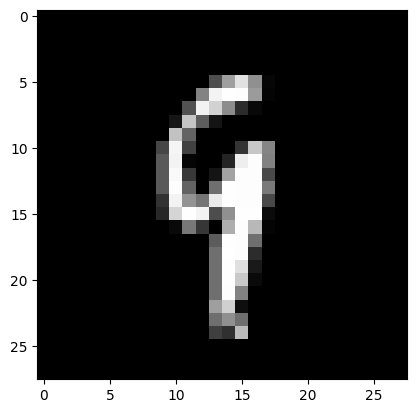

Label: 9


In [9]:
# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[22]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[22]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [10]:
print('pixel [0,0]: ',img[0][0])
print('pixel maximo: ', torch.max(img))
print('pixel minimo: ', torch.min(img))

pixel [0,0]:  tensor(0.)
pixel maximo:  tensor(1.)
pixel minimo:  tensor(0.)


## 3. Construyo mi CNN

#### Bloque de convolución

defino primero un "bloque" de una capa CNN
construido con los bloques funcionales vistos en clase

(hiper)parámetros a pasar a la función:

  - `c_in`:   canales (kernels) de entrada
  - `c_out`:  canales (kernels) de salida
  - `k`:      tamaño del kernel kxk
  - `p`:      tamaño del padding de la convolución
  - `s`:      stride de la convolución
  - `pk`:     tamaño del kernel del pooling
  - `ps`:     stride de la pooling
  - `pp`:     padding en la pooling

la función pooling se elige directamente dentro del bloque!

In [11]:
# bloque de convolución para emplear en mi red

def conv_block(c_in, c_out, k=5, p=2, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )


### Red convolucional (modelo)


Ahora SI construyo mi red... usando la clase CNN de pytorch
revisar muy bien las dimensiones a emplear en cada capa y
tener presente la reducción de las dimensiones.

En la útlima capa fully conected `fc`, hacer bien el cálculo final del
tamaño del array que se obtiene siguiendo la formula vista en la teoria
tanto para la capa conv como para la capa pooling.

In [39]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block(20, 32)
    self.conv3_out = None
    # self.conv4 = conv_block(128, 128)
    # self.conv4_out = None
    self.fc = torch.nn.Linear(512, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)


    print('Red creada')
    print('arquitectura:')
    print(self)

    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    # x = self.conv4(x)
    # print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    # self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [41]:
model = CNN()


Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(20, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  4
Número total de parámetros a entrenar:  24586


In [35]:
summary(model.cuda(),(1, 28, 28) )

RuntimeError: ignored

## 4. Veamos que las dimensiones sean consistentes.

In [42]:
model.cpu()
model.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 8, 14, 14])
Tamaño salida conv2:  torch.Size([1, 16, 7, 7])


RuntimeError: ignored

## 5. Armo las funciones necesarias

In [18]:
from tqdm import tqdm # <- para graficar la barra de avance


def fit(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))

        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))

    plt.figure()
    plt.plot(epoch_t_loss, 'r')
    plt.plot(epoch_v_loss, 'g')
    plt.title('loss')
    plt.legend(['train loss', 'val loss'])
    plt.grid()

    plt.figure()
    plt.plot(epoch_t_acc, 'r')
    plt.plot(epoch_v_acc, 'g')
    plt.title('acc')
    plt.legend(['train acc', 'val acc'])
    plt.grid()
    plt.show()

## 6. Entreno la red

val_loss 0.14867 val_acc 0.95711: 100%|██████████| 157/157 [00:01<00:00, 91.29it/s]


Epoch 1/5 loss 0.62070 val_loss 0.14867 acc 0.84243 val_acc 0.95711


val_loss 0.08546 val_acc 0.97412: 100%|██████████| 157/157 [00:01<00:00, 91.51it/s]


Epoch 2/5 loss 0.12505 val_loss 0.08546 acc 0.96394 val_acc 0.97412


val_loss 0.06452 val_acc 0.97960: 100%|██████████| 157/157 [00:01<00:00, 91.74it/s]


Epoch 3/5 loss 0.08381 val_loss 0.06452 acc 0.97548 val_acc 0.97960


val_loss 0.05063 val_acc 0.98318: 100%|██████████| 157/157 [00:02<00:00, 76.12it/s]


Epoch 4/5 loss 0.06525 val_loss 0.05063 acc 0.98038 val_acc 0.98318


val_loss 0.04269 val_acc 0.98567: 100%|██████████| 157/157 [00:01<00:00, 84.75it/s]


Epoch 5/5 loss 0.05332 val_loss 0.04269 acc 0.98434 val_acc 0.98567


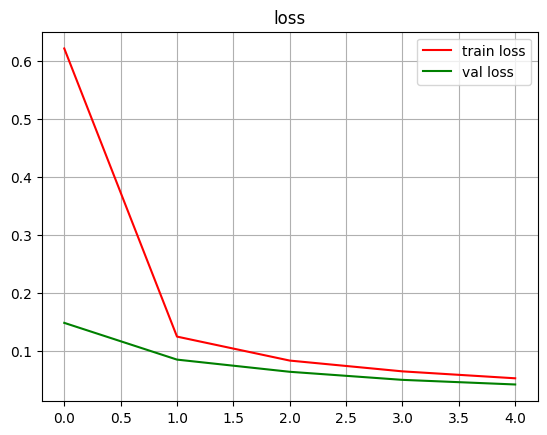

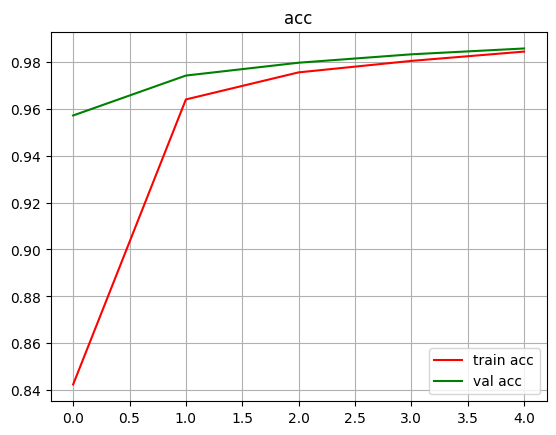

In [19]:
fit(model, dataloader, epochs=5)

## 7. Vemos que funcione.

torch.Size([1, 28, 28])
tensor(0.)
tensor(0.9961)
tensor(0.)


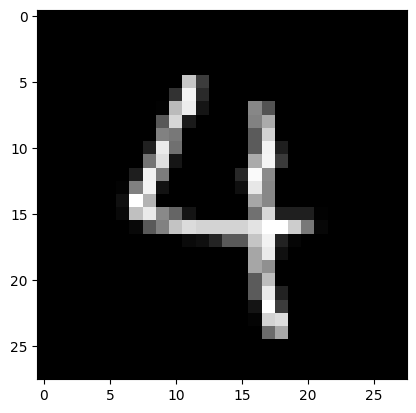

Tamaño imagen de entrada a red:  torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[-0.9808, -0.8903, -0.5639, -5.2951, 10.1112, -2.0827, -0.9022,  0.5053,
         -1.9282,  1.5475]], device='cuda:0')

softmax de predicción:
tensor([[1.5229e-05, 1.6672e-05, 2.3107e-05, 2.0371e-07, 9.9966e-01, 5.0595e-06,
         1.6474e-05, 6.7309e-05, 5.9049e-06, 1.9085e-04]], device='cuda:0')

El numero es un:  4


In [22]:
# corremos 1 dato, a ver como lo clasifica...
# generamos un batch del dataloader
test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = 24

# verifico las dimensiones y los valores que toma algun pixel.
samp_img = test_features[k]
print(samp_img.shape)
print(samp_img[0][0][0])
print(torch.max(samp_img))
print(torch.min(samp_img))

# ploteo la imagen
plt.imshow(samp_img.squeeze(), cmap='gray')
plt.show()

# preparo para pasarla a la red (model) asi predice.
samp_imp = samp_img.unsqueeze(0) # agrego la batch dim
samp_img = samp_img.unsqueeze(0).to(device)
print('Tamaño imagen de entrada a red: ', samp_img.shape)

# la paso al modelo
model.eval()
y_hat = model(samp_img)
print('Predición del modelo:')
print(y_hat.detach())
print()
print('softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())





# EJERCICIO NRO 1

## Probemos con un número nuestro!
Primero lo dibujamos en el paint con un tamaño próximo a 28x28 pixeles
(el tamaño del papel puede ser aproximado)...
Después haremos un `resize`.
Usar un marcador grueso que pinte varios pixeles!!!!

Cargamos el archivo hecho a mano

In [23]:
# lo leemos
num_ex = torchvision.io.read_image('cero.png')
#num_ex= torchvision.io.read_image('/content/drive/My Drive/CIA_marcos/deep_learning/clase_5/tres.png')

Veamos el tamaño, datatype y el valor de 1 pixel.

In [24]:
print('shape imagen: ', num_ex.shape)
print('data type imagen: ', num_ex.dtype)
# convertimos a float
num_ex = num_ex.float()
print('nuevo data type: ', num_ex.dtype)
print('valor pixel superior izq: ', num_ex[0][0][0])

shape imagen:  torch.Size([3, 45, 43])
data type imagen:  torch.uint8
nuevo data type:  torch.float32
valor pixel superior izq:  tensor(255.)


Realizamos un conjunto de transformaciones para llevar la imagen al valor deseado:
- resize a 28x28
- convertir a escala de grises
- escalar ente 0 y 1 (dividimos por 255)
- normalizar

In [25]:
adaptacion = torchvision.transforms.Compose([
                                             torchvision.transforms.Resize(size=(28,28)),
                                             torchvision.transforms.Grayscale(num_output_channels=1), #<---------- IMPORTANTE!
                                             torchvision.transforms.Normalize((0,), (255,))#,
                                             #torchvision.transforms.Normalize((0.1307,), (0.3081,)), #<---------- IMPORTANTE!
                                            ])

Una ultima transformación (que no se pudo colocar dentro del compose) es la de invertir los colores, ya que MNIST tiene fondo negro con letra blanca.

In [26]:
# aplicamos la transformación
num_ex_adap = adaptacion(num_ex)

# para invertir el color (blanco y negro)
num_ex_adap = torchvision.transforms.functional.invert(num_ex_adap)

print('nuevo tamaño de imagen: ', num_ex_adap.shape)
print('pixel [0,0]: ',num_ex_adap[0][0][0])
print('pixel máximo: ', torch.max(num_ex_adap))
print('pixel mínimo: ', torch.min(num_ex_adap))

nuevo tamaño de imagen:  torch.Size([1, 28, 28])
pixel [0,0]:  tensor(9.9957e-05)
pixel máximo:  tensor(1.)
pixel mínimo:  tensor(9.9838e-05)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Veamos como quedó

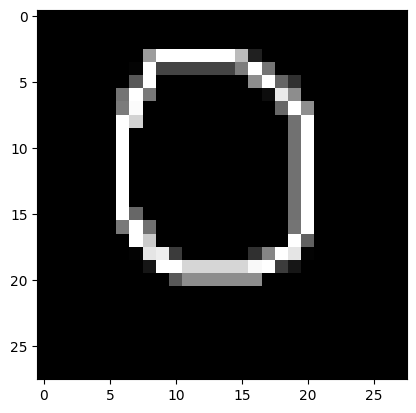

In [27]:
# ponemos el squeeze para eliminar el canal (1ra dimension)
plt.imshow(num_ex_adap.squeeze(), cmap='gray')
plt.show()

Lo pasamos por la red...
RECORDAR DE MANEJAR TODO EN EL MISMO `DEVICE`

In [29]:
# le agregamos el batch y lo mandamos a device
num_ex_adap_batch = num_ex_adap.unsqueeze(0).cpu()
print('Tamaño entrada:   ',num_ex_adap_batch.shape)

# enviamos al modelo al device
model.cpu()

# pasamos la entrada al modelo
y_hat = model(num_ex_adap_batch)
print()
print('Salida red:  ')
print(y_hat.detach())
print()
print('Salida softmax(salida red):')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())

Tamaño entrada:    torch.Size([1, 1, 28, 28])

Salida red:  
tensor([[ 3.5922, -3.8910,  3.9977, -1.7973, -3.0098, -0.7277, -0.4196, -1.7764,
         -3.7529,  0.9738]])

Salida softmax(salida red):
tensor([[3.8222e-01, 2.1499e-04, 5.7339e-01, 1.7446e-03, 5.1896e-04, 5.0843e-03,
         6.9190e-03, 1.7814e-03, 2.4682e-04, 2.7872e-02]])

El numero es un:  2


El mismo proceso en 1 sola celda.

In [31]:
# todo junto
num_ex = torchvision.io.read_image('nueve.png').float()
num_ex_adap = adaptacion(num_ex)
num_ex_adap = torchvision.transforms.functional.invert(num_ex_adap)
# le agregamos el batch y lo mandamos a device
num_ex_adap_batch = num_ex_adap.unsqueeze(0).cpu()
model.cpu()

y_hat = model(num_ex_adap_batch)
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())

El numero es un:  8
